## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [60]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pmdarima as pmd
import numpy as np
from sklearn.svm import SVR
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
warnings.filterwarnings('ignore')

# Nạp dữ liệu từ file csv

In [61]:
df = pd.read_csv('../../../data/clean/btc.csv')
df.pop('volume')
df.pop('high')
df.pop('open')
df.pop('low')
df.pop('adjclose')
df = df.reset_index()
df['formatted_date'] = pd.to_datetime(df['formatted_date']).values.astype(np.int64)
df.set_index("formatted_date",inplace=True)
df.pop('index')
df.pop('Unnamed: 0')
df_low = df['low'].values.reshape(-1, 1)

df

,close
formatted_date,
1546300800000000000,3943.409424
1546387200000000000,3836.741211
1546473600000000000,3857.717529
1546560000000000000,3845.194580
1546646400000000000,4076.632568
...,...
1681948800000000000,27276.910156
1682035200000000000,27817.500000
1682121600000000000,27591.384766


# Chuẩn hóa dữ liệu

In [62]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['low'] = arima_sc.fit_transform(df_low)
df_scaled

,close
formatted_date,
1546300800000000000,-1.160522
1546387200000000000,-1.166824
1546473600000000000,-1.165585
1546560000000000000,-1.166324
1546646400000000000,-1.152651
...,...
1681948800000000000,0.218032
1682035200000000000,0.249971
1682121600000000000,0.236612


# Vẽ đồ thị

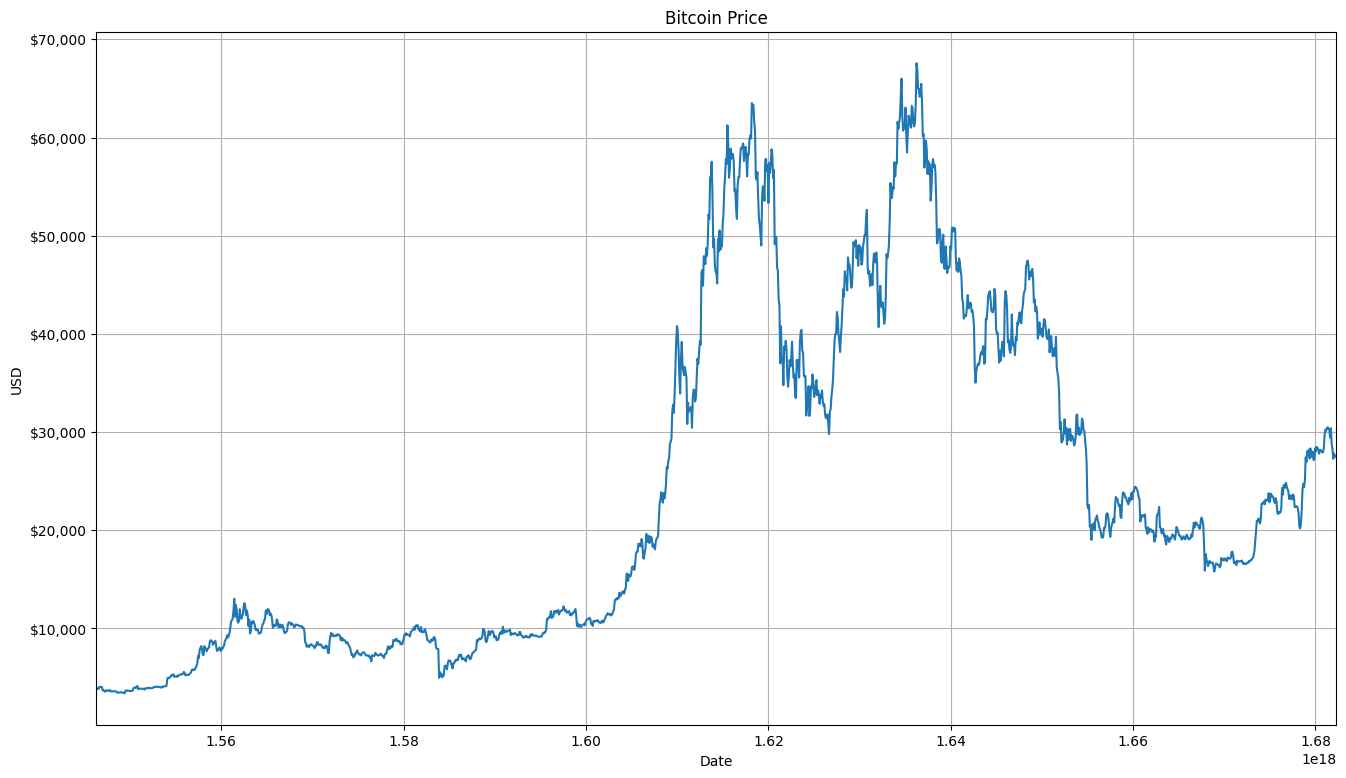

In [63]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['low'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [64]:
train, test = df_scaled[:(int)(len(df_scaled) * 1)], df_scaled[(int)(len(df_scaled) * 1):]
index_test = df_scaled.index[:(int)(len(df_scaled) * 1)]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (1575, 1)
test shape:  (0, 1)


# Hàm kiểm định chuỗi dừng

In [65]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [66]:
adf_test(train['low'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic          -1.592909
p-value                      0.487155
Number of lags used         24.000000
Number of observations    1550.000000
critical value (1%)         -3.434576
critical value (5%)         -2.863406
critical value (10%)        -2.567764
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

<Axes: xlabel='formatted_date'>

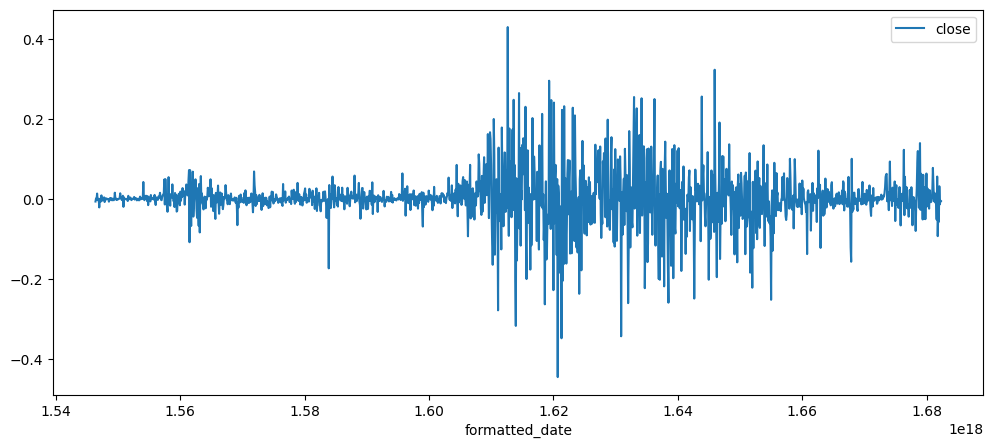

In [67]:
diff_1 = train.dropna().diff()
diff_1.plot(figsize=(12,5))

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [68]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic       -7.811727e+00
p-value                   7.040552e-12
Number of lags used       2.300000e+01
Number of observations    1.550000e+03
critical value (1%)      -3.434576e+00
critical value (5%)      -2.863406e+00
critical value (10%)     -2.567764e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [69]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [70]:
import pickle
arima_model = ArimaModel(train)
arima_model.summary()
with open("../../../models/low/arima_model.pkl", "wb") as f:
        pickle.dump(arima_model, f)
    

    
    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4175.193, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4180.647, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4180.049, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4180.022, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4182.348, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4178.091, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.580 seconds


# Dự đoán trên tập test

In [71]:
pred = arima_model.predict(len(train))
pred


1575    0.227564
1576    0.227564
1577    0.227564
1578    0.227564
1579    0.227564
          ...   
3145    0.227564
3146    0.227564
3147    0.227564
3148    0.227564
3149    0.227564
Length: 1575, dtype: float64

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [72]:
inv_test = arima_sc.inverse_transform(train.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

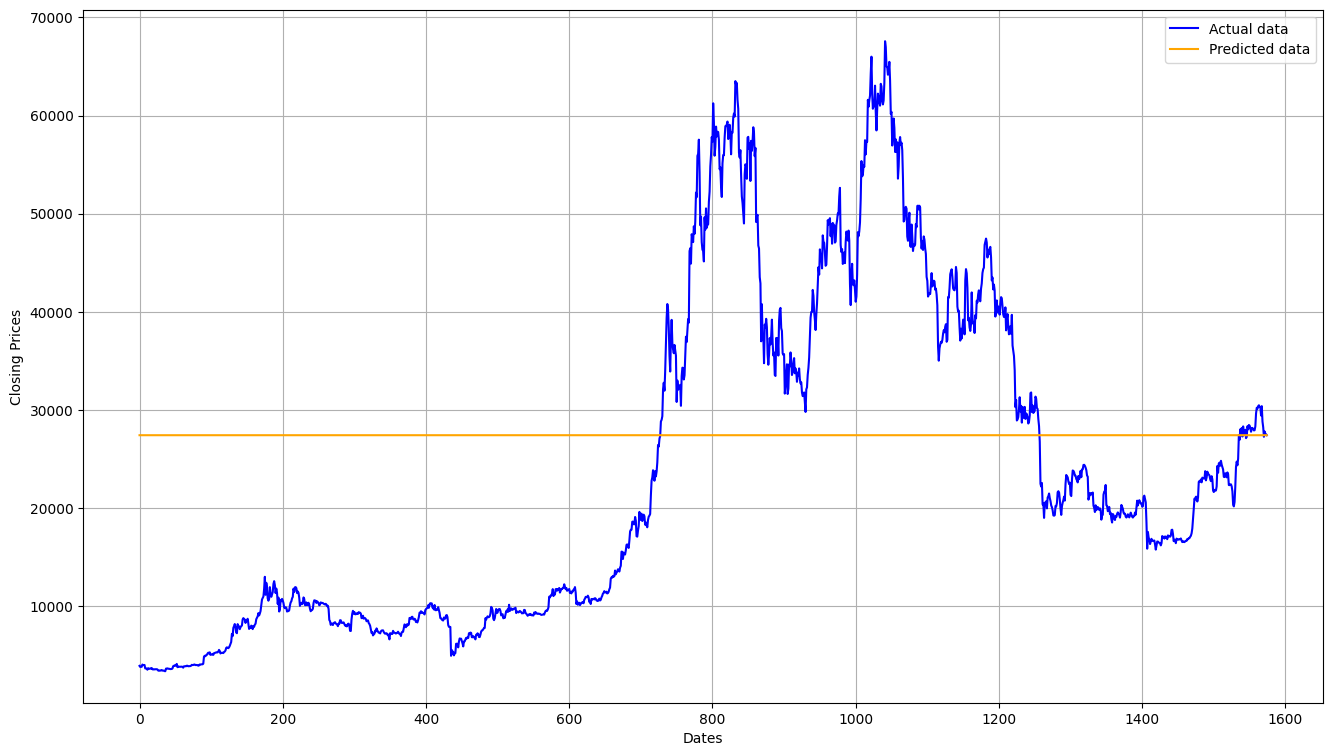

In [73]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [74]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 15495.46
MAPE: 136.26%
MSE: 301327732.71
RMSE: 17358.79
R2: -0.05


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [75]:
df_pred = pd.DataFrame(index=index_test)
df_pred['actual'] = inv_test
df_pred['arima'] = inv_pred
df_pred['error'] = inv_test - inv_pred
df_pred

,actual,arima,error
formatted_date,,,
1546300800000000000,3943.409424,27438.240234,-23494.830811
1546387200000000000,3836.741211,27438.240234,-23601.499023
1546473600000000000,3857.717529,27438.240234,-23580.522705
1546560000000000000,3845.194580,27438.240234,-23593.045654
1546646400000000000,4076.632568,27438.240234,-23361.607666
...,...,...,...
1681948800000000000,27276.910156,27438.240234,-161.330078
1682035200000000000,27817.500000,27438.240234,379.259766
1682121600000000000,27591.384766,27438.240234,153.144531


## 2. Quá trình dự đoán trên mô hình svr

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình svr

In [76]:
df_svr = df_pred.copy()
df_svr

,actual,arima,error
formatted_date,,,
1546300800000000000,3943.409424,27438.240234,-23494.830811
1546387200000000000,3836.741211,27438.240234,-23601.499023
1546473600000000000,3857.717529,27438.240234,-23580.522705
1546560000000000000,3845.194580,27438.240234,-23593.045654
1546646400000000000,4076.632568,27438.240234,-23361.607666
...,...,...,...
1681948800000000000,27276.910156,27438.240234,-161.330078
1682035200000000000,27817.500000,27438.240234,379.259766
1682121600000000000,27591.384766,27438.240234,153.144531


# Vẽ đồ thị thể hiện sai số

In [77]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

df_svr = df_svr.drop(columns=['actual', 'arima'])
timestamp = pd.to_datetime(df_svr.index).astype(np.int64) / 10**9
df_svr['timestamp'] = timestamp
df_svr.tail()

,error,timestamp
formatted_date,,
1681948800000000000,-161.330078,1.681949e+09
1682035200000000000,379.259766,1.682035e+09
1682121600000000000,153.144531,1.682122e+09
1682208000000000000,87.099609,1.682208e+09
1682294400000000000,0.000000,1.682294e+09


In [78]:
svr_x_sc = StandardScaler()
svr_y_sc = StandardScaler()

x = df_svr.iloc[:, -1].values
y = df_svr.iloc[:, 0].values

x_scaled = svr_x_sc.fit_transform(x.reshape(-1, 1))
y_scaled = svr_y_sc.fit_transform(y.reshape(-1, 1))

print(x_scaled.shape)
print(y_scaled.shape)

(1575, 1)
(1575, 1)


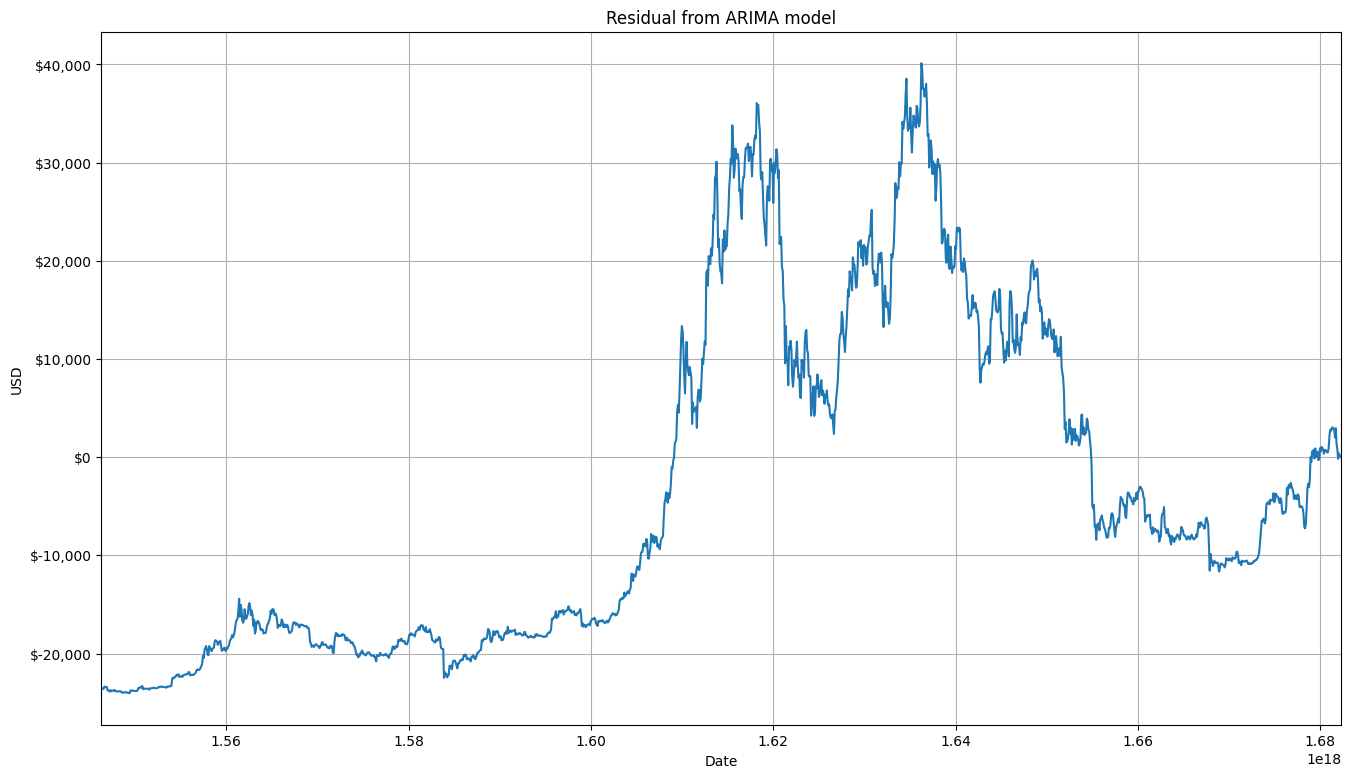

In [79]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = df_svr['error'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)


In [80]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MSE={stats[1] :.2f} | RMSE={stats[2]:.2f}")

In [81]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)

In [82]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(x_scaled, y_scaled)
                pred = rgs.predict(x_scaled)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = svr_y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_y = svr_y_sc.inverse_transform(
                    column_or_1d(y_scaled).reshape(-1, 1))

                # Đánh giá mô hình
                mae = mean_absolute_error(inv_y, inv_pred)
                mse = mean_squared_error(inv_y, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma,
                          'degree': 0, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma,
                              degree=deg, verbose=False)
                    rgs.fit(x_scaled, y_scaled)
                    pred = rgs.predict(x_scaled)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = svr_y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_y = svr_y_sc.inverse_transform(
                        column_or_1d(y_scaled).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_y, inv_pred)
                    mse = mean_squared_error(inv_y, inv_pred)
                    rmse = np.sqrt(mse)

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mse, rmse]
                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                              'MAE': mae, 'MSE': mse, 'RMSE': rmse}

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=10657.67 | MSE=268926830.11 | RMSE=16398.99
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=10581.43 | MSE=262477636.83 | RMSE=16201.16
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=10672.15 | MSE=259480675.80 | RMSE=16108.40
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=10984.34 | MSE=271441996.77 | RMSE=16475.50
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=11657.08 | MSE=291355908.31 | RMSE=17069.15
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=12655.49 | MSE=314268191.54 | RMSE=17727.61
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=13668.38 | MSE=336433505.26 | RMSE=18342.12
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=14801.53 | MSE=368565227.80 | RMSE=19198.05
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=15839.54 | MSE=402158030.72 | RMSE=20053.88
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=16706.02 | MSE=436573853.80 | RMSE=20894.35
SVR(kernel=sigmoid, C=0.01, gamma=1.1
MAE=17483.93 | MSE=471174273.42 | RMSE=21706.55
SVR(kernel=sigmoid, C=0

In [83]:
best_fit_model = stats_df[stats_df['RMSE'] == stats_df['RMSE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MSE,RMSE
195,rbf,0.11,4.9,0,3321.325157,2.667707e+07,5164.984997


In [84]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)

rgs.fit(x_scaled, y_scaled)
pred = rgs.predict(x_scaled)

pred

array([-1.06306904, -1.06484087, -1.06656591, ...,  0.26382109,
        0.26787687,  0.27190099])

In [85]:
with open("../../../models/low/svr_model.pkl", "wb") as f:
        pickle.dump(rgs, f)